<a href="https://www.kaggle.com/code/siddp6/flower-images-classification?scriptVersionId=139107576" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Crafting an AI Application

The future sees AI algorithms integrated into everyday applications. For instance, think of an image classifier in a smartphone app, powered by a deep learning model trained on vast image datasets. This integration of models into applications will become a staple in software development.

This project focuses on training an image classifier to recognize flower species. Imagine a camera app identifying flowers. We'll use a dataset of [102 flower categories](https://www.kaggle.com/datasets/siddp6/flower-dataset). The project involves:

- Loading and preprocessing the image dataset
- Training the classifier
- Using it for image predictions


In [1]:
# Importing required packages

import os 
import json 
import torch 

import torch.nn.functional as F  
import numpy as np 
import matplotlib.pyplot as plt  

from torch import nn 
from torch import optim  
from torchvision import datasets, transforms, models 
from PIL import Image 

In [2]:
# Set up matplotlib for inline plotting with high-resolution figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Hyperparameters
batch_size = 64  
epochs = 10  
learning_rate = 0.001  
criterion = nn.NLLLoss()  

# Other constants
input_size = 25088  
output_size = 102  
hidden_layers = 512  
drop_rate = 0.2  

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

## Loading and Pre-Process the Data

In [4]:
# Set the directory paths for training, validation, and testing data
data_dir = '/kaggle/input/flower-dataset/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
# Creating a normalization transform that adjusts image values to have a standard mean and deviation
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], 
    std=[0.229, 0.224, 0.225] 
)

data_transforms = {}

# For training data: Randomly crop and resize to 224x224, then convert to tensor and normalize
data_transforms['train'] = transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(.5), # randomly flips images horizontally with a probability of 0.5 (50% chance).
    transforms.RandAugment(num_ops=2, magnitude=15), #  operations like color adjustments, rotations, translations, shears, and more.
    transforms.ToTensor(), 
    normalize 
])

# For validation data: Randomly crop and resize to 224x224, then convert to tensor and normalize
data_transforms['val'] = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(), 
    normalize 
])

# For test data: Randomly crop and resize to 224x224, then convert to tensor and normalize
data_transforms['test'] = transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.ToTensor(),  
    normalize 
])


In [6]:
# Load the datasets using ImageFolder, a generic data loader where the images are arranged in this way by defa
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']), 
    'val': datasets.ImageFolder(valid_dir, transform=data_transforms['val']),  
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test']) 
}

# Create dataloaders for the datasets
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size, shuffle=True), 
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=32, shuffle=True) 
}

In [7]:
# A mapping of category names to labels
cat_to_name = {"21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

# Building and Training the Classifier


In [8]:
# Load a pre-trained VGG16 model
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s]


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class MyNetwork(nn.Module):
    """
    A simple feedforward neural network model.

    Args:
        input_size (int): Number of input features.
        hidden_units (int): Number of hidden units in the layers.
        drop_rate (float): Dropout rate for regularization.
        output_size (int): Number of output classes.

    Attributes:
        layer1 (nn.Linear): First fully connected layer.
        layer2 (nn.Linear): Second fully connected layer.
        layer3 (nn.Linear): Third fully connected layer.
        dropout (nn.Dropout): Dropout layer for regularization.
        output (nn.LogSoftmax): Log-softmax activation for classification.
    """
    def __init__(self, input_size, hidden_units, drop_rate, output_size):
        super().__init__()

        self.layer1 = nn.Linear(input_size, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units // 2)
        self.layer3 = nn.Linear(hidden_units // 2, output_size)

        self.dropout = nn.Dropout(drop_rate)

        self.output = nn.LogSoftmax(dim=1)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        out = self.layer1(x)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.layer2(out)
        out = F.relu(out)
        out = self.dropout(out)

        out = self.layer3(out)

        out = self.output(out)

        return out

In [10]:
model.classifier = MyNetwork(input_size, hidden_layers, drop_rate, output_size)

In [11]:
import torch

def get_validation(model, device, loaders, criterion):
    """
    Calculate loss and accuracy on the validation dataset.

    Args:
        model (torch.nn.Module): The neural network model.
        device (torch.device): The device (CPU or GPU) for computation.
        dataloaders (dict): Dictionary containing data loaders for training and validation.
        criterion (torch.nn.Module): The loss function.

    Returns:
        tuple: A tuple containing loss and accuracy values.
    """
    loss, accuracy = 0, 0

    model.to(device) 

    for images, labels in loaders:
        images, labels = images.to(device), labels.to(device)
        output = model(images)  
        loss += criterion(output, labels).detach()*images.size(0)
        ps = torch.exp(output)
        equity = labels == ps.max(dim=1)[1]  
        accuracy += equity.type(torch.FloatTensor).mean()

    return loss / len(loaders.dataset), 100 * accuracy / len(loaders)

In [12]:
def train_network():
    """
    Train the network using the specified data loaders and settings.

    Returns:
        torch.nn.Module: The trained model.
    """
    trainloader = dataloaders["train"]  

    model.to(device)  

    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)  # Use Adam optimizer for model's classifier parameters


    for epoch in range(epochs):  
        training_loss = 0  
        for images, labels in trainloader:  
            images, labels = images.to(device), labels.to(device)  
            optimizer.zero_grad() 
            
            output = model(images) 
            
            Loss = criterion(output, labels)  

            Loss.backward() 
            
            optimizer.step() 

            training_loss += Loss.item() 

        model.eval() 
        with torch.no_grad():  
            loss, accuracy = get_validation(model, device, dataloaders["val"], criterion) 

        print(
            f"Epoch: {epoch + 1}/{epochs}\n"
            f"Training Loss: {training_loss / len(dataloaders['train']):.4f}\n"
            f"Validation Loss: {loss / len(dataloaders['val']):.4f}\n"
            f"Validation Accuracy: {accuracy:.2f}%\n\n"
        )

        model.train()  

    return model  

In [13]:
# Trains a neural network and returns the trained model
trained_model = train_network()

Epoch: 1/10
Training Loss: 3.5179
Validation Loss: 0.1471
Validation Accuracy: 51.08%


Epoch: 2/10
Training Loss: 2.2203
Validation Loss: 0.0992
Validation Accuracy: 65.53%


Epoch: 3/10
Training Loss: 1.8499
Validation Loss: 0.0831
Validation Accuracy: 71.28%


Epoch: 4/10
Training Loss: 1.6722
Validation Loss: 0.0842
Validation Accuracy: 68.57%


Epoch: 5/10
Training Loss: 1.5821
Validation Loss: 0.0646
Validation Accuracy: 78.24%


Epoch: 6/10
Training Loss: 1.5182
Validation Loss: 0.0680
Validation Accuracy: 75.99%


Epoch: 7/10
Training Loss: 1.4615
Validation Loss: 0.0696
Validation Accuracy: 75.58%


Epoch: 8/10
Training Loss: 1.4470
Validation Loss: 0.0708
Validation Accuracy: 76.55%


Epoch: 9/10
Training Loss: 1.4008
Validation Loss: 0.0592
Validation Accuracy: 78.36%


Epoch: 10/10
Training Loss: 1.3298
Validation Loss: 0.0610
Validation Accuracy: 79.78%




## Evaluating Your Network

In [14]:
# Use the torch.no_grad() context to disable gradient computation
with torch.no_grad():
    # Call the get_test_validation() function to get accuracy and total
    _, accuracy = get_validation(model, device, dataloaders["test"], criterion)

# Print the accuracy as a percentage
print('Accuracy: {}%\n'.format(accuracy))

Accuracy: 69.69255828857422%



## Save the checkpoint

In [15]:
def save_model(save_dir):
    """
    Save the trained model checkpoint.

    Args:
        save_dir (str): Path to the directory where the checkpoint will be saved.
    """
    checkpoint = {
        "architecture": 'vgg16', 
        "state_dict": model.state_dict(),  # Save the model's learned weights
        "class_to_idx": image_datasets['train'].class_to_idx,  # Mapping of classes to indices
        'model': models.vgg16(pretrained=True), 
        'classifier': model.classifier  # Save the custom classifier part of the model
    }

    torch.save(checkpoint, save_dir) 

In [16]:
save_model('checkpoint.pth')  # Save the model to a file named 'checkpoint.pth'

## Loading the checkpoint

Now is a good time to create a function that can load a checkpoint and reconstruct the model. This will allow you to resume working on your project later without the need to retrain the network from scratch.


In [17]:
def get_loaded_model(checkpoint):
    """
    Load a pre-trained model from a checkpoint.

    Args:
        checkpoint (str): The path to the checkpoint file.

    Returns:
        torch.nn.Module: The loaded pre-trained model.
    """
    # Load the checkpoint
    checkpoint = torch.load(checkpoint)

    # Extract necessary components from the checkpoint
    model = checkpoint['model']
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    # Freeze model parameters to prevent gradient updates during inference
    for param in model.parameters():
        param.requires_grad = False

    return model

In [18]:
# Load a previously saved model from a checkpoint file
model = get_loaded_model('checkpoint.pth')

# Inference for Classification

In this section, you will create a function to use a trained network for inference. The goal is to pass an image through the network and predict the class of the flower shown in the image. To accomplish this, you'll define a function called `predict` that takes an image and a model as inputs. The function will then return the top *K* most likely classes along with their corresponding probabilities. The usage will look like this:

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [0.01558163, 0.01541934, 0.01452626, 0.01443549, 0.01407339]
> ['70', '3', '45', '62', '55']
```
First, you need to handle preprocessing the input image to make it compatible with your network.

## Image Preprocessing

1. Utilize the PIL library to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)).
2. It's recommended to create a function that preprocesses the image, adapting it for use as input in your model. This function should process the images in the same manner they were treated during training.
3. Start by resizing the images, making the shortest side 256 pixels while preserving the aspect ratio. This can be achieved using the `thumbnail` or `resize` methods.
4. Following resizing, crop the central 224x224 portion of the image.
5. Image color channels are usually encoded as integers ranging from 0 to 255. However, the model expects values between 0 and 1 in float format. You will need to perform this conversion. You can obtain a Numpy array from a PIL image using `np_image = np.array(pil_image)`.
6. Just like during training, the network anticipates images to be normalized in a specific way. The means are `[0.485, 0.456, 0.406]`, and the standard deviations are `[0.229, 0.224, 0.225]`. Subtract the means from each color channel and then divide by the standard deviation.
7. Lastly, PyTorch expects the color channel to be the first dimension, while it's the third dimension in both the PIL image and the Numpy array. You can rearrange dimensions using `ndarray.transpose`. The color channel needs to be the first dimension while maintaining the order of the other two dimensions.


To verify your progress, the function provided below converts a PyTorch tensor and visualizes it within the notebook. If your `process_image` function is functioning correctly, passing the output through this function should yield the original image (with the exception of cropped sections).


In [19]:
def imshow(image, title=None):
    """
    Display an image using matplotlib.

    Args:
        image (torch.Tensor): The image to display, should be in tensor format.
        title (str, optional): Title for the displayed image. Default is None.
    """
    fig, ax = plt.subplots()  # Create a new figure and axis
    
    image = data_transforms['test'](Image.open(image))
    
    # Transpose the image from tensor format (C, H, W) to (H, W, C)
    image = image.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])  # Mean values for normalization
    std = np.array([0.229, 0.224, 0.225])   # Standard deviation values for normalization
    
    # Normalize and clip the image pixel values to the range [0, 1]
    image = (std * image) + mean
    image = np.clip(image, 0, 1)
    
    if title:
        ax.set_title(title)  # Set the title if provided
    ax.imshow(image)  # Display the image

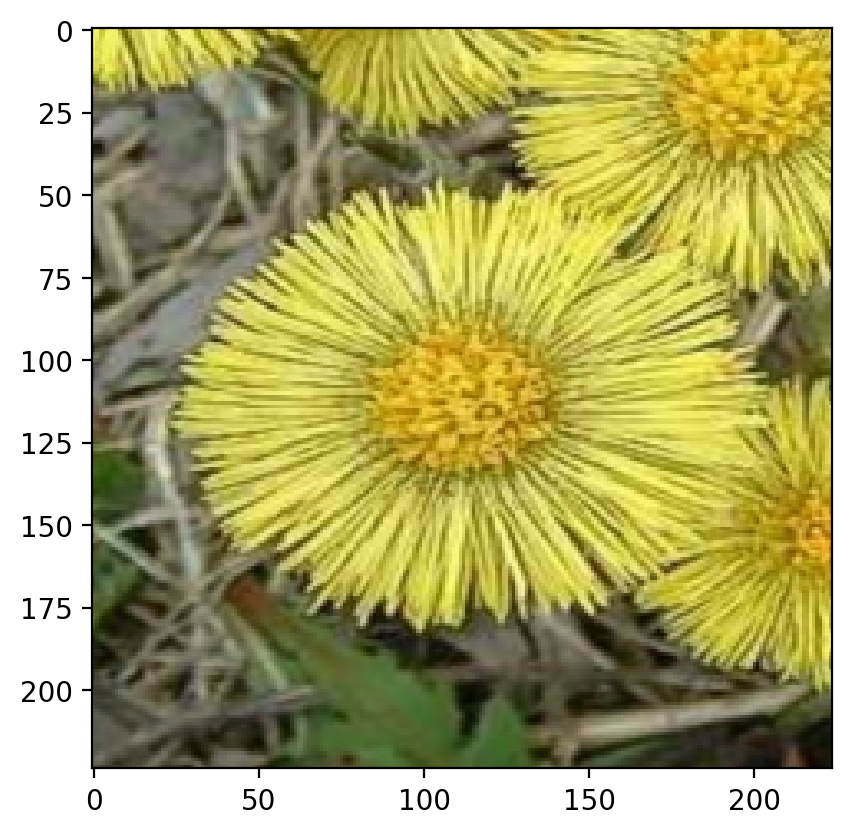

In [20]:
imshow('/kaggle/input/flower-dataset/flowers/test/12/image_03994.jpg')

## Class Prediction

To make predictions with your model using images in the correct format, you'll need to implement a prediction function. It's a common practice to predict the top 5 (often referred to as top-$K$) most probable classes. Here's how you can achieve this:

1. Calculate class probabilities.
2. Find the top $K$ largest values among the probabilities.

You can use the [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk) method to get the top $K$ probabilities and their corresponding indices. After obtaining the indices, you'll need to convert them into actual class labels using the `class_to_idx` mapping. If you've added this mapping to the model or used an `ImageFolder` to load the data ([see here](#Save-the-checkpoint)), you can perform this conversion. Remember to invert the dictionary so that you can map from index to class as well.

Your prediction function should take the path to an image and a model checkpoint as input, and return the predicted probabilities and class labels. Here's a sample code snippet:

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [21]:
def get_prediction(image_path, model, device, topk=5):
    """
    Get predictions for an image using a trained model.

    Args:
        image_path (str): Path to the input image.
        model (torch.nn.Module): The trained neural network model.
        device (str): Device to perform computations on (e.g., 'cuda' or 'cpu').
        topk (int): Number of top predictions to return.

    Returns:
        tuple: A tuple containing arrays of predicted probabilities and corresponding class labels.
    """
    # Process the image and prepare it for prediction
    image =  data_transforms['test'](Image.open(image_path)).unsqueeze(0).float()
    
    # Move model and image to the specified device
    model, image = model.to(device), image.to(device)
    
    # Set the model in evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Perform forward pass through the model
        results = torch.exp(model.forward(image))
        
        # Get the topk predictions
        result_top_k = results.topk(topk)
        
        # Extract predicted probabilities and class indices
        probs, classes = result_top_k[0].data.cpu().numpy()[0], result_top_k[1].data.cpu().numpy()[0]
        
        # Convert class indices to actual class labels using class_to_idx mapping
        idx_to_class = {key: value for value, key in model.class_to_idx.items()}
        classes = [idx_to_class[classes[i]] for i in range(classes.size)]

    return probs, classes

In [22]:
# Get predictions using the get_prediction function
probs, predict_classes = get_prediction(
    '/kaggle/input/flower-dataset/flowers/test/12/image_03994.jpg', model, device
)

print(predict_classes)

print(probs)

['12', '49', '54', '48', '42']
[9.9994981e-01 4.1146075e-05 5.8566229e-06 1.9214751e-06 5.2056436e-07]


## Sanity Checking

After training a model and generating predictions, it's important to perform a sanity check to ensure the predictions make sense. Even if the testing accuracy is high, it's always a good practice to verify for any possible bugs or anomalies. To achieve this, you can utilize the `matplotlib` library to create a bar graph showing the probabilities of the top 5 predicted classes, alongside the input image. The visualization might resemble the following example:


To convert from the class integer encoding to actual flower names, utilize the `cat_to_name.json` file that should have been loaded earlier in the notebook. Additionally, to display a PyTorch tensor as an image, you can utilize the `imshow` function defined above.


In [23]:
def view_classify(image_path, probs, classes):
    """
    Display an image with its predicted class probabilities.

    Args:
        image_path (str): Path to the image file.
        probs (list): List of predicted class probabilities.
        classes (list): List of predicted class indices.

    Returns:
        None
    """
    # Get the names of the predicted classes using cat_to_name dictionary
    name = [cat_to_name[i] for i in classes]
    
    # Display the processed image using imshow
    imshow(image_path, cat_to_name[classes[0]])

    # Create a figure with two subplots (image and graph)
    _, (ax_img, ax_gph) = plt.subplots(nrows=2)
    
    # Turn off the axis for the image subplot
    ax_img.axis('off')
    
    # Create a horizontal bar graph for class probabilities
    ax_gph.barh(np.arange(len(name)), probs)
    
    # Set y-ticks to class indices and labels to class names
    ax_gph.set_yticks(np.arange(len(name)))
    ax_gph.set_yticklabels(name)
    
    # Invert the y-axis for a better display
    ax_gph.invert_yaxis()

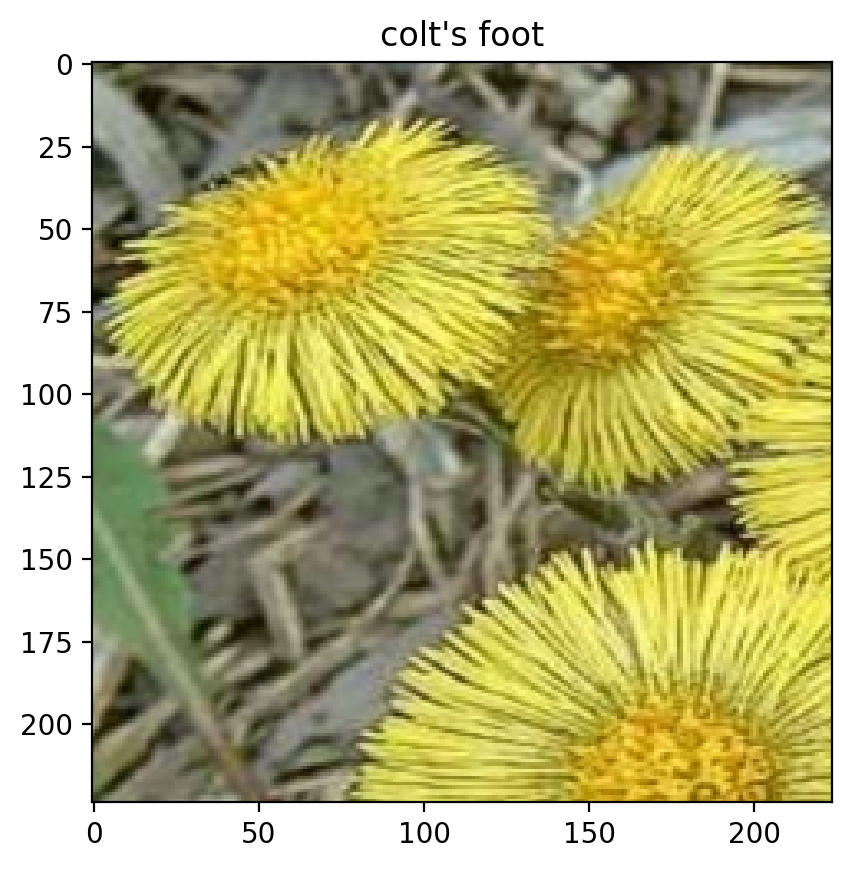

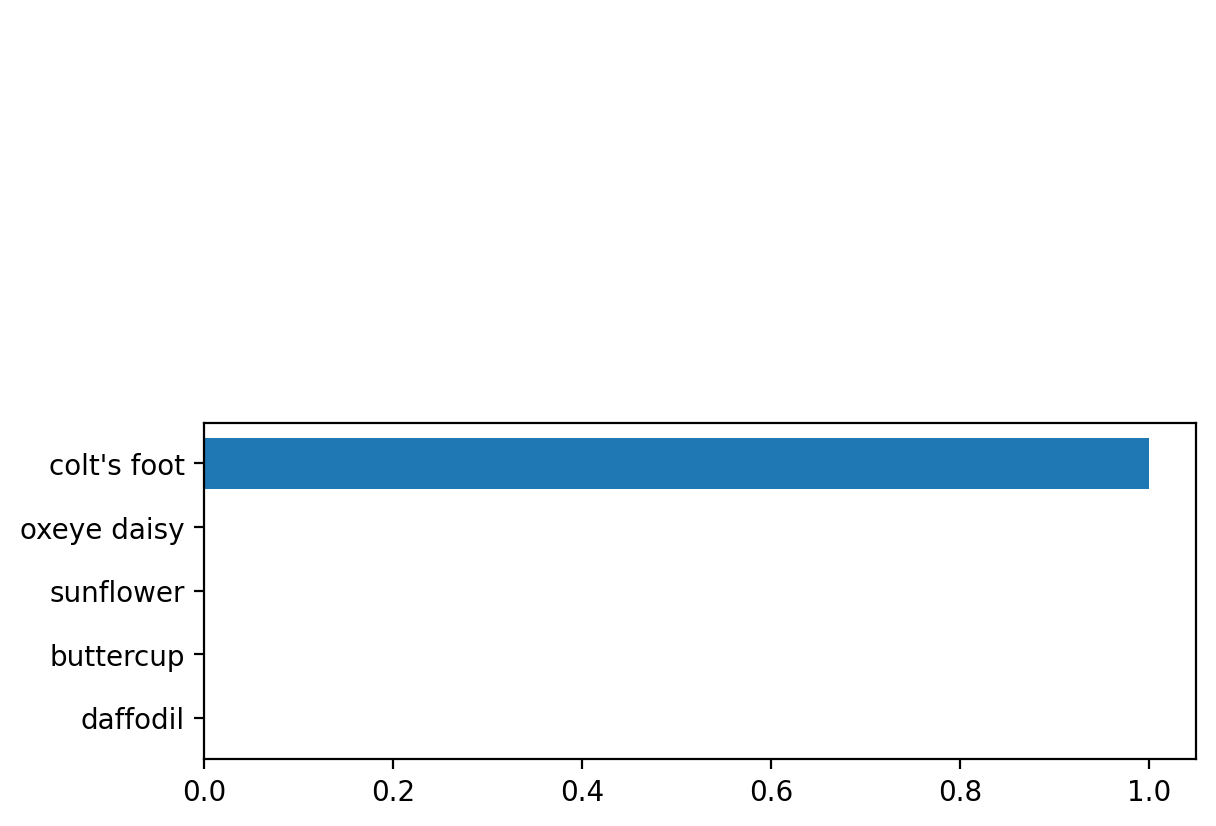

In [24]:
# Call the function 'view_classify' to visualize classification results for a specific image
view_classify('/kaggle/input/flower-dataset/flowers/test/12/image_03994.jpg', probs, predict_classes)